In [1]:
import pickle
import os
import re
from collections import Counter
import math
import matplotlib.pyplot as plt
import random
import json
import datetime
import string
string.punctuation += '➡•’'
import numpy as np
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib
import spacy
import pandas as pd

In [2]:
nlp=spacy.load('en_core_web_md', disable=['parser', 'tagger', 'ner'])

In [3]:
# sp_tokens = ['de', 'la', 's', 'm', 'las', 'los', 'p', 've', 'en', 're', 'del', 't', 'que' ]

In [4]:
dem = pickle.load(open('../../data/all_tweet_texts_dem.p', 'rb'))
rep = pickle.load(open('../../data/all_tweet_texts_rep.p', 'rb'))


In [5]:
data_path = '../../data/'
house_rep_screennames = pickle.load(open(data_path+'house_rep_screennames.p', 'rb'))
house_dem_screennames = pickle.load(open(data_path+'house_dem_screennames.p', 'rb'))
senate_dem_screennames = pickle.load(open(data_path+'senate_dem_screennames.p', 'rb'))
senate_rep_screennames = pickle.load(open(data_path+'senate_rep_screennames.p', 'rb'))
govenor_rep_screennames = pickle.load(open(data_path+'govenor_rep_screennames.p', 'rb'))
govenor_dem_screennames = pickle.load(open(data_path+'govenor_dem_screennames.p', 'rb'))

In [6]:
all_screenname = set(house_rep_screennames + house_dem_screennames + senate_dem_screennames + senate_rep_screennames\
                + govenor_rep_screennames + govenor_dem_screennames)

In [9]:
# covid_vocab = pickle.load(open('../../data/all_covid_words.p', 'rb'))

In [10]:
# big_regex = re.compile('|'.join(map(re.escape, covid_vocab)))

In [11]:
def get_covid_tweets(df):
    all_covid_tweets = []
    all_bg_tweets = []
    for idx, row in df.iterrows():
        try:
            t = row['Text']
            if 'covid' in t or 'coronavirus' in t:
                all_covid_tweets.append(row)
            else:
                all_bg_tweets.append(row)
        except Exception as ex:
            continue
        
    return pd.DataFrame(all_covid_tweets), pd.DataFrame(all_bg_tweets)

In [12]:
dem_covid, dem_bg = get_covid_tweets(dem)
rep_covid, rep_bg = get_covid_tweets(rep)
bg = pd.concat([dem_bg, rep_bg])

In [13]:
dem_bg.head(2)

,Text,Time
0,Trump Admin’s disturbing use of unidentified f...,2020-07-22 20:34:49
1,The health of American people &amp; U.S. econo...,2020-07-22 20:15:22


In [14]:
len(dem_covid), len(rep_covid), len(bg)

(15620, 9953, 413550)

In [15]:
exclude_words = set(['Ricketts', 'RepPressley', 'Beshear', 'GregHilburn1', 'HouseDemocrats', 'RepBera', 'OversightDems', 
 'WaysandMeansGOP', 'dougducey', 'SteveScalise', 'HouseGOP', 'SecretarySonny', 'Hutchinson', 'GOPoversight',
 'AsaHutchinson','GOPLeader', 'GovRicketts','WhiteHouse','m', 'ChadSabadie', 'HouseCommerce','✓'])

In [16]:
# def get_monthly_data(month):
#     if month == 'feb':
#         dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 2, 1)) & (dem['Time'] < datetime.datetime(2020, 3, 1))]
#         rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 2, 1)) & (rep['Time'] < datetime.datetime(2020, 3, 1))]
#         bg_month = pickle.load(open('../../data/moe_sample_tweets_feb.p', 'rb'))
#     elif month == 'mar':
#         dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 3, 1)) & (dem['Time'] < datetime.datetime(2020, 4, 1))]
#         rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 3, 1)) & (rep['Time'] < datetime.datetime(2020, 4, 1))]
#         bg_month = pickle.load(open('../../data/moe_sample_tweets_mar.p', 'rb'))

#     elif month == 'apr':
#         dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 4, 1)) & (dem['Time'] < datetime.datetime(2020, 5, 1))]
#         rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 4, 1)) & (rep['Time'] < datetime.datetime(2020, 5, 1))]
#         bg_month = pickle.load(open('../../data/moe_sample_tweets_apr.p', 'rb'))
#     else:
#         print('month must be feb, mar, or apr')
#     return dem_month, rep_month, bg_month

In [17]:
# month = 'apr'

In [18]:
# dem_month, rep_month, bg_month = get_monthly_data(month)

In [19]:
# print(len(dem_month), len(rep_month), len(bg_month))

In [20]:
dem.tail()

,Text,Time
274678,"This #BlackHistoryMonth, we honor the African-...",2020-02-02 02:50:28
274679,RT @DhhsNevada: NV has no confirmed cases of n...,2020-02-01 18:03:12
274680,RT @ChiefNGB: Saw firsthand today how the @NVN...,2020-02-01 16:41:04
274681,"RT @UNLVLaw: Our thanks to @GovSisolak, @ThomR...",2020-02-01 15:40:27
274682,In Las Vegas and want to learn more about the ...,2020-02-01 15:21:49


In [21]:
punc = string.punctuation.replace("#", '')

In [22]:
punc

'!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~➡•’'

In [23]:
def preprocess_text(dem, rep, bg):
    dem = dem.Text.tolist()
    dem = [t.replace('\n', '').replace('&amp', 'and').translate(str.maketrans('', '', punc)) for t in dem]
    dem_tokenized = [token.text for t in dem for token in nlp(t)]
    dem_tokenized = [t for t in dem_tokenized if t not in all_screenname and t not in exclude_words]
    rep = rep.Text.tolist()
    rep = [t.replace('\n', '').replace('&amp', 'and').translate(str.maketrans('', '', punc)) for t in rep]
    rep_tokenized = [token.text for t in rep for token in nlp(t)]
    rep_tokenized = [t for t in rep_tokenized if t not in all_screenname and t not in exclude_words]
    bg = bg.Text.tolist()
    bg = [t.replace('\n', '').replace('&amp', 'and').translate(str.maketrans('', '', punc)) for t in bg]
    bg_tokenized = [token.text for t in bg for token in nlp(t)]
    bg_tokenized = [t for t in bg_tokenized if t not in all_screenname and t not in exclude_words]

    dem_counter=  Counter(dem_tokenized)
    rep_counter= Counter(rep_tokenized)
    bg_counter = Counter(bg_tokenized)
    return dem_counter, rep_counter, bg_counter

In [24]:
dem_counter, rep_counter, bg_counter = preprocess_text(dem_covid, rep_covid, bg)

In [25]:
len(bg_counter), len(dem_counter), len(rep_counter)

(233989, 23279, 17286)

In [26]:
dem_counter['covid']

142

In [27]:
rep_counter['covid19']

118

In [28]:
bg_counter['covid']

0

In [29]:
def logodds(corpora_dic, bg_counter):
    """ It calculates the log odds ratio of term i's frequency between 
    a target corpus and another corpus, with the prior information from
    a background corpus. Inputs are:
    
    - a dictionary of Counter objects (corpora of our interest)
    - a Counter objects (background corpus)
    
    Output is a dictionary of dictionaries. Each dictionary contains the log 
    odds ratio of each word. 
    
    """
    corp_size = dict([(c, sum(corpora_dic[c].values())) for c in corpora_dic])
    bg_size = sum(bg_counter.values())
    result = dict([(c, {}) for c in corpora_dic])
    
    for name, c in corpora_dic.items():
        for word in c:
            #if 10 > sum(1 for corpus in corpora_dic.values() if corpus[word]):
            #    continue
            
            fi = c[word]
            fj = sum(co[word] for x, co in corpora_dic.items() if x != name)
            fbg = bg_counter[word]+0.0001
            ni = corp_size[name]
            nj = sum(x for idx, x in corp_size.items() if idx != name)
            nbg = bg_size
#             print(fi+fbg,ni+nbg-(fi+fbg),fj+fbg,nj+nbg-(fj+fbg))
            oddsratio = math.log(fi+fbg) - math.log(ni+nbg-(fi+fbg)) -\
                        math.log(fj+fbg) + math.log(nj+nbg-(fj+fbg))
            std = 1.0 / (fi+fbg) + 1.0 / (fj+fbg)
            z = oddsratio / math.sqrt(std)
            result[name][word] = z
            
    return result

In [30]:
result = logodds({'Republican_tweets': rep_counter, 'Democratic_tweets': dem_counter}, bg_counter)

In [31]:
top_rep = sorted(result['Republican_tweets'], key=result['Republican_tweets'].get, reverse=True)[0:50]

In [32]:
top_rep

['China',
 'Wuhan',
 'Hoosiers',
 'Coron',
 'MI06',
 'NC10',
 'Chinese',
 'realDonaldTrump',
 'Communist',
 'InItTogether',
 'Coming',
 'MSDH',
 'Pelosis',
 '1077RKR',
 'sneaking',
 'RADIO',
 'Chinas',
 'ActHeres',
 'Speaker',
 'Indiana',
 'MarcBernierShow',
 'CLEAN',
 'newlypassed',
 'Hoosier',
 'FM',
 '→',
 'msdh',
 'Party',
 '1150',
 'AZ05',
 'TX12',
 'Mississippi',
 '935',
 'MPShiels',
 'Louisianians',
 'FoxNews',
 '1450whtc',
 'WSBT',
 'Hawley',
 'Pelosi',
 '📻',
 'CCP',
 'ELBOW',
 'TipsFromDocCaucus',
 'WNZF',
 'BerrienCountyMI',
 'ALERT',
 'propaganda',
 'POSTPONED',
 'AndyShain']

In [167]:
rep_place = ['BerrienCountyMI','Louisianians','Mississippi','msdh','Hoosier','Indiana',
            ]

In [168]:
rep_people_entities = ['AndyShain','TipsFromDocCaucus','CCP','propaganda','Pelosi','Hawley','MPShiels',\
                       'Party','Speaker','China','Communist','realDonaldTrump','Chinese','Wuhan',
                      
                      ]

In [169]:
rep_media = ['WSBT','WNZF','1450whtc','FoxNews','FM','MarcBernierShow','RADIO','1077RKR',
            ]

In [170]:
rep_crisis_response=['ALERT','ELBOW','newlypassed','POSTPONED','CLEAN','ActHeres','InItTogether',]

In [171]:
len(rep_place+rep_people_entities+rep_media+rep_crisis_response)

35

In [172]:
set(rep_place+rep_people_entities+rep_media+rep_crisis_response)-set(top_rep)

set()

In [116]:
# set(top_rep)-set(rep_place+rep_people_entities+rep_crisis_response+rep_media)

In [117]:
top_dem = sorted(result['Democratic_tweets'], key=result['Democratic_tweets'].get,reverse=True)[0:50]


In [ ]:
['coronavirus',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',




In [180]:
dem_place = ['Massachusettsbased']

In [181]:
dem_people_entities = ['Trump','Arwady',]

In [182]:
dem_social_issue = []

In [183]:
dem_media = ['Join','ASK','teletown','answer','tele','questions','hall',]

In [185]:
dem_crisis_response = ['leave', 'coronavirus','testing','governmentwide','crisis','public',\
                      'experts','coronaviruspandemic','sick','emergency','response','pandemic','telephone',
                      'fullyfunded','health','FamiliesFirst','covid','covid19'
                      ]

In [186]:
set(dem_place+dem_people_entities+dem_social_issue+dem_crisis_response)-set(top_dem)

set()

In [187]:
# set(top_words)-set(dem_place+dem_other+dem_social_issue+dem_crisis_response+dem_media)

In [188]:
len(dem_place+dem_social_issue+dem_crisis_response+dem_media+rep_people_entities)

40

In [211]:
from numpy import interp

def plot_logodds(results,  month, num_words=15):
    # the two groups of interest
    rep_dic = results['Republican_tweets']
    dem_dic = results['Democratic_tweets']
    # sort to get the most over-represented and under-represented
    rep = {k: rep_dic[k]*3 for k in sorted(rep_dic, key=rep_dic.get, reverse=True)[0:num_words]}
    dem = {k: -dem_dic[k] for k in sorted(dem_dic, key=dem_dic.get, reverse=True)[0:num_words]}
    blue_minima = min(dem.values())
    blue_maxima = max(dem.values())
    blue_norm = matplotlib.colors.Normalize(vmin=blue_minima+27, vmax=blue_maxima, clip=True)
    blue_mapper = cm.ScalarMappable(norm=blue_norm, cmap=cm.Blues_r)
    
    red_minima = min(rep.values())
    red_maxima = max(rep.values())
    red_norm = matplotlib.colors.Normalize(vmin=red_minima-10, vmax=red_maxima, clip=True)
    red_mapper = cm.ScalarMappable(norm=red_norm, cmap=cm.Reds)
                    
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    all_text = []
    for word in rep_place:
        t = ax.text(rep[word], random.randrange(0,35)/100, word, \
                    c=red_mapper.to_rgba(rep[word]), fontsize=13)
        all_text.append(t)
    for word in rep_people_entities:
        t = ax.text(rep[word], random.randrange(38,58)/100, word, \
                    c=red_mapper.to_rgba(rep[word]), fontsize=13)
        all_text.append(t)
    for word in rep_media:
        t = ax.text(rep[word], random.randrange(62,80)/100, word, \
                    c=red_mapper.to_rgba(rep[word]), fontsize=13)
        all_text.append(t)
    for word in rep_crisis_response:
        t = ax.text(rep[word], random.randrange(82,100)/100, word, \
                    c=red_mapper.to_rgba(rep[word]), fontsize=13)
        all_text.append(t)
    
    plt.text(max(rep.values())+6,0.2, 'Places', fontsize=15)
    plt.text(max(rep.values())+6,0.5, 'People & entities', fontsize=15)
    plt.text(max(rep.values())+6,0.7, 'Media', fontsize=15)
    plt.text(max(rep.values())+6,0.9, 'Crisis response', fontsize=15)
    
    rep_l1 = ax.plot([0, max(rep.values())+5], [0.36, 0.36], c='orange')
    rep_l2 = ax.plot([0,max(rep.values())+5], [0.6, 0.6], c='orange')
    rep_l3 = ax.plot([0,max(rep.values())+5], [0.81, 0.81], c='orange')

    
    for word in dem_place:
        t = ax.text(dem[word], random.randrange(0,30)/100, word, \
                    c=blue_mapper.to_rgba(dem[word]), fontsize=13)
        all_text.append(t)
    for word in dem_people_entities:
        t = ax.text(dem[word], random.randrange(32,38)/100, word, \
                    c=blue_mapper.to_rgba(dem[word]), fontsize=13)
        all_text.append(t)
    for word in dem_media:
        t = ax.text(dem[word], random.randrange(42,55)/100, word, \
                    c=blue_mapper.to_rgba(dem[word]), fontsize=13)
        all_text.append(t)
    for word in dem_crisis_response:
        t = ax.text(dem[word], random.randrange(57,100)/100, word, \
                    c=blue_mapper.to_rgba(dem[word]), fontsize=13)
        all_text.append(t)
    plt.text(min(dem.values())-14,0.17, 'Places', fontsize=15)
    plt.text(min(dem.values())-14,0.35, 'Social issues', fontsize=15)
    plt.text(min(dem.values())-14,0.48, 'Media', fontsize=15)
    plt.text(min(dem.values())-14,0.7, 'Crisis response', fontsize=15)
    
    ax.plot([min(dem.values())-8,0], [0.31, 0.31], c='green')
    ax.plot([min(dem.values())-8,0], [0.4, 0.4], c='green')
    ax.plot([min(dem.values())-8,0], [0.55, 0.55], c='green')

    
#     text2 = [ax.text(group2_overrep_values[idx], random.random(), group2_overrep_keys[idx],
#                      c=blue_mapper.to_rgba(group2_overrep_values[idx]), fontsize=13) for idx in range(num_words)]             

    line = ax.plot([0,0], [0,1], c='black')
    


    ax.set_xlim(min(dem.values())-3, max(rep.values())+10)
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.annotate('Overrepresented in Republican tweets',fontsize=15, xy=(1, -0.095), xycoords='axes fraction', xytext=(0.6, -0.1), 
            arrowprops=dict(arrowstyle="->", color='r'))
    ax.annotate('Overrepresented in Democratic tweets',fontsize=15, xy=(0, -0.095), xycoords='axes fraction', xytext=(0.1, -0.1), 
            arrowprops=dict(arrowstyle="->", color='b'))
    ax.set_xlabel('$z-score$', fontsize=15)
    
#     ax.yaxis.set_ticks([])
#     ax.set_xlabel('Log odds ratio', fontsize=15)
#     ax.set_ylabel('Demoratic overrep words', fontsize=15)
#     ax2 = ax.twinx()
#     ax2.set_ylabel('Republican overrep words', fontsize=15)



        
#     if month == 'feb':
#         ax.set_title('February 2020', fontsize=15)
#     elif month == 'mar':
#         ax.set_title('March 2020', fontsize=15)
#     elif month == 'apr':
#         ax.set_title('April 2020', fontsize=15)
    adjust_text(all_text, expand_text=(1.2, 1.01), force_text=(0.75, 0.75), \
                lim=20,only_move={'text':'x'})#add_objects=[line, rep_l1,rep_l2, rep_l3]
    plt.tight_layout()
#     plt.savefig('logodds_{}_.pdf'.format(month), format='pdf')

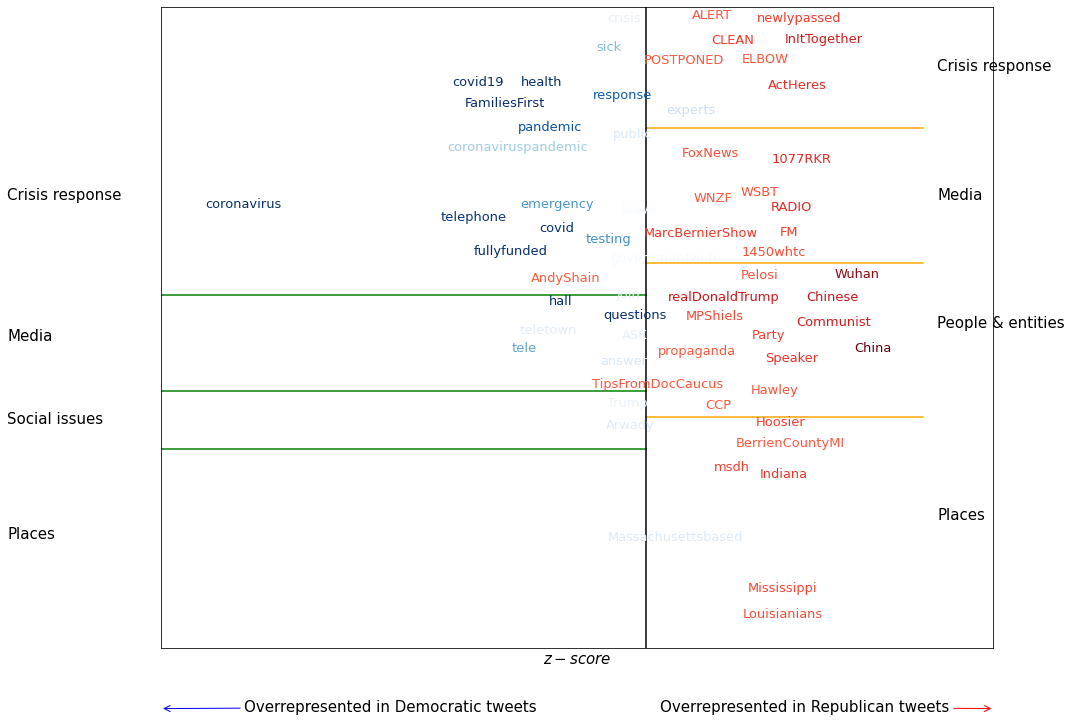

In [212]:
plot_logodds(result,  month='All', num_words=50)